In [1]:
import h5py
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imageio import imread
from skimage.color import rgb2hed, hed2rgb, rgb2gray
from skimage.util import img_as_ubyte

## Create HDF5

In [2]:
DATA_DIR = 'data/'
FILENAME = 'data.hdf5'

In [3]:
TRAIN_DIR = DATA_DIR + 'train/'
TRAIN_FILES = os.listdir(TRAIN_DIR)
len(TRAIN_FILES)

220025

In [4]:
TEST_DIR = DATA_DIR + 'test/'
TEST_FILES = os.listdir(TEST_DIR)
len(TEST_FILES)

57458

In [5]:
IMG_SIZE = (96, 96)

In [6]:
df = pd.read_csv(DATA_DIR + 'train_labels.csv')
TRAIN_IDS = [ df[df['label'] == 0]['id'].values.tolist(), df[df['label'] == 1]['id'].values.tolist() ]

In [7]:
TEST_IDS = [os.path.splitext(p)[0] for p in TEST_FILES]

In [8]:
# The HED color deconv, rgb2hed(), produces values outside of 0 and 1 for some images.
# Workaround - use hed2rgb() with each HED channel separately and then run rgb2gray()
# on that conversion result
def rgb2ghed(img_rgb: np.ndarray) -> np.ndarray:
    assert img_rgb.dtype == 'uint8'
    assert img_rgb.shape == IMG_SIZE + (3,)
    img_hed = rgb2hed(img_rgb)
    img_z = np.zeros(img_rgb.shape[:2])
    img_h = img_as_ubyte(rgb2gray(hed2rgb(np.stack((img_hed[:, :, 0], img_z, img_z), axis=-1))))
    img_e = img_as_ubyte(rgb2gray(hed2rgb(np.stack((img_z, img_hed[:, :, 1], img_z), axis=-1))))
    img_d = img_as_ubyte(rgb2gray(hed2rgb(np.stack((img_z, img_z, img_hed[:, :, 2]), axis=-1))))
    img_g = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    img_ghed = np.stack((img_g, img_h, img_e, img_d), axis=-1)
    return img_ghed

In [9]:
def create_train_dsets(label: int, m: int, n_chars: int=10):
    count_pos, count_neg = 0, 0
    for id in TRAIN_IDS[label][:m]:
        img_rgb = imread(TRAIN_DIR + id + '.tif')
        img_ghed = rgb2ghed(img_rgb)
        # shorten name of individual datasets in HDF5
        name = id[-n_chars:]
        # print(name)
        dset = g_train.create_dataset(name, data=img_ghed)
        dset.attrs['label'] = label
        if label == 1:
            count_pos += 1
        elif label == 0:
            count_neg += 1
        else:
            raise Exception

In [10]:
def create_test_dsets(m: int, n_chars: int=10):
    for id in TEST_IDS[:m]:
        img_rgb = imread(TEST_DIR + id + '.tif')
        img_ghed = rgb2ghed(img_rgb)
        # shorten name of individual datasets in HDF5
        name = id[-n_chars:]
        # print(name)
        g_test.create_dataset(name, data=img_ghed)

In [11]:
f = h5py.File(DATA_DIR + FILENAME, 'w-')
g_train = f.create_group('train')
g_test = f.create_group('test')

In [12]:
# create_test_dsets(10)
create_test_dsets(len(TEST_IDS))

In [13]:
# create_train_dsets(0, 10)
create_train_dsets(0, len(TRAIN_IDS[0]))

In [14]:
# create_train_dsets(1, 10)
create_train_dsets(1, len(TRAIN_IDS[1]))

In [15]:
f.close()

In [16]:
# assert False

## Check / Inspect HDF5

In [17]:
f = h5py.File(DATA_DIR + FILENAME, 'r')

In [18]:
f.keys()

<KeysViewHDF5 ['test', 'train']>

In [19]:
len(f['train']), len(f['test'])

(220025, 57458)

In [20]:
train_ids = list(f['train'])[:5]
train_ids

['00004f1436', '00007fe223', '0000b61c31', '0000d4f3c2', '00011aa91b']

In [21]:
labels = [ f['train'][x].attrs['label'] for x in train_ids ]
labels

[1, 0, 0, 1, 0]

In [22]:
sum(labels)

2

In [23]:
test_ids = list(f['test'])[:5]
test_ids

['0001acfdab', '000332e930', '0003fc0451', '00059d8e71', '0006a11fbc']

In [24]:
def show_ghed(img):
    fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(6,6))
    ax11.set_title('G')
    ax12.set_title('H')
    ax21.set_title('E')
    ax22.set_title('D')
    ax11.imshow(img[:, :, 0], cmap='gray')
    ax12.imshow(img[:, :, 1], cmap='gray')
    ax21.imshow(img[:, :, 2], cmap='gray')
    ax22.imshow(img[:, :, 3], cmap='gray')
    fig.tight_layout()

In [25]:
it = iter(f['train'])

((96, 96, 4), dtype('uint8'))

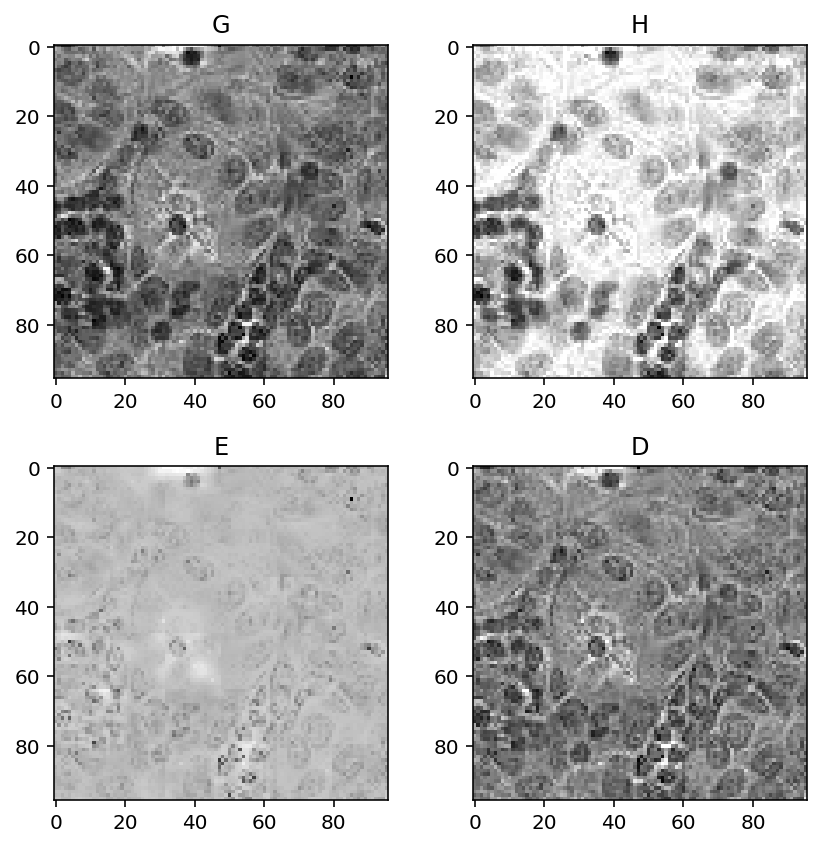

In [26]:
img = f['train'][next(it)]
show_ghed(img)
img.shape, img.dtype

In [27]:
f.close()